In [42]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import glob
import utils
import matplotlib.colors as colors
import cmaps
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
from scipy.stats import pearsonr, t as tdist
from scipy.stats import t

In [43]:
def pvalue_array(x,y,dname):
    x_an=x-x.mean(dname)
    y_an=y-y.mean(dname)
    slope=(x_an*y_an).sum(dname)/(x_an*x_an).sum(dname)
    interc=y.mean(dname)-slope*x.mean(dname)
    ypred=slope*x+interc
    n=len(x[dname])
    mse=np.sqrt(((y-ypred)**2).sum(dname)/(n-2))
    xsq=np.sqrt(((x_an)**2).sum(dname))
    standerr=mse/xsq
    pval=2*(1-t.cdf(np.abs(slope/standerr),n-2))
    pval=xr.DataArray(pval,dims=standerr.dims,coords=standerr.coords)
    return pval

def rvalue_array(x,y,dname):
    xmean=x.mean(dname)
    ymean=y.mean(dname)
    numer=(x*y).mean(dname)-xmean*ymean
    denom=np.sqrt(((x**2).mean(dname)-xmean**2)*(((y**2).mean(dname))-(ymean**2)))
    return numer/denom

def regcoeff_array(x,y,dname):
    x_an=x-x.mean(dname)
    y_an=y-y.mean(dname)
    slope=(x_an*y_an).sum(dname)/(x_an*x_an).sum(dname)
    return slope

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg, skipna=True)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def trend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg, skipna=True)
    return p

In [44]:
datadir='/Projects/RAPrototype/ERA5'
plotdir='/home/ghervieux/SCRIPTS/GEV/PLOTS'

In [45]:
state_borders =\
cartopy.feature.NaturalEarthFeature(category='cultural',\
        name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

In [46]:
yearb=1979
yeare=2023

# GLOST 

In [47]:
fileGLOST = f'/data/ghervieux/AFI/NOAA_GLOST_anomaly.csv'
df_glost=pd.read_csv(fileGLOST,skiprows=4)
df_glost['Year']=pd.to_datetime(df_glost['Year'], format='%Y%m')

In [48]:
ds_glost=df_glost.set_index(['Year']).to_xarray()
sm_x, smooth_glost = sm_lowess(ds_glost['Anomaly'], ds_glost['Year'],  frac=(30*12)/len(ds_glost['Year']), 
                           it=5, return_sorted = True).T
smooth_glost=xr.DataArray(smooth_glost,dims=['time'],coords={'time':ds_glost['Year'].data})  

In [49]:
def ann_mean(var):
    month_length = var.time.dt.days_in_month
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    var_ann = (var*wgts).groupby("time.year").sum()
    return var_ann

In [50]:
ann_glost=ann_mean(smooth_glost)
ann_glost=ann_glost.rename({'year':'time'})
ann_glost = ann_glost.sel(time=slice(yearb,yeare))
ann_glost = ann_glost.rename({'time':'year'})

# Read Colorado

In [51]:
lon_min = 250.6
lon_max = 258.5
lat_min = 36.7
lat_max = 41.3

In [52]:
def preprocess(ds):
    return ds.\
            sel(lon=slice(lon_min,lon_max)).\
            sel(lat=slice(lat_max,lat_min))

# Read Coldest Day ERA5

In [53]:
temp_var='coldest_tmin'
year=np.arange(yearb,yeare+1,1)

In [54]:
files=[f'{datadir}/Coldest_Day.era5.{iyear}.nc' for iyear in year]
dstmin = xr.open_mfdataset(files,combine='nested', concat_dim='year', preprocess=preprocess)
dstmin = dstmin.sortby('lat')
dstmin =dstmin.load()
dstmin['year'] = year.astype('int64')
units='$\degree$K'
trend_tmin = trend_dim(dstmin['coldest_tmin'],'year')


<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_594182/3961977661.py:6: SyntaxWarning: invalid escape sequence '\d'
  units='$\degree$K'


<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_594182/1379219559.py:17: SyntaxWarning: invalid escape sequence '\d'
  ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
/tmp/ipykernel_594182/1379219559.py:19: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)


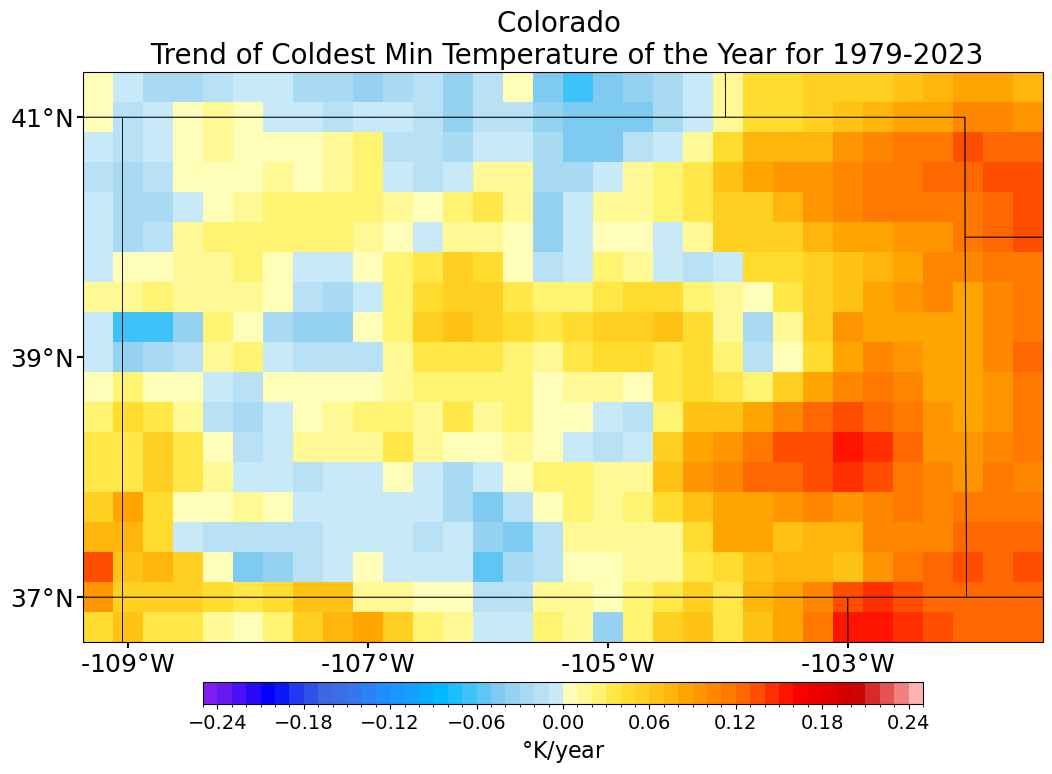

In [55]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,11),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15,left=0.1, right=0.9)
cc=trend_tmin['polyfit_coefficients'].sel(degree=1).plot.pcolormesh(ax=ax,cmap=cmap,levels=np.arange(-0.25,0.26,0.01),add_colorbar=False)
####
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'{units}/year',fontsize=16)

ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()
ax.set_title(f'Colorado \n Trend of Coldest Min Temperature of the Year for {yearb}-{yeare}',fontsize=20)  
plt.suptitle('')  
outfile=f'PLOTS/Trend_Coldest_Tmin_{yearb}_{yeare}_COLORADO.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Read Hottest Day ERA5

In [56]:
temp_var='hottest_tmax'
year=np.arange(yearb,yeare+1,1)

In [57]:
files=[f'{datadir}/Hottest_Day.era5.{iyear}.nc' for iyear in year]
dstmax = xr.open_mfdataset(files,combine='nested', concat_dim='year', preprocess=preprocess)
dstmax = dstmax.sortby('lat')
dstmax = dstmax.load()
dstmax['year'] = year.astype('int64')
units='$\degree$K'
trend_tmax = trend_dim(dstmax['hottest_tmax'],'year')

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_594182/1559492259.py:6: SyntaxWarning: invalid escape sequence '\d'
  units='$\degree$K'


<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_594182/4019033760.py:17: SyntaxWarning: invalid escape sequence '\d'
  ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
/tmp/ipykernel_594182/4019033760.py:19: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)


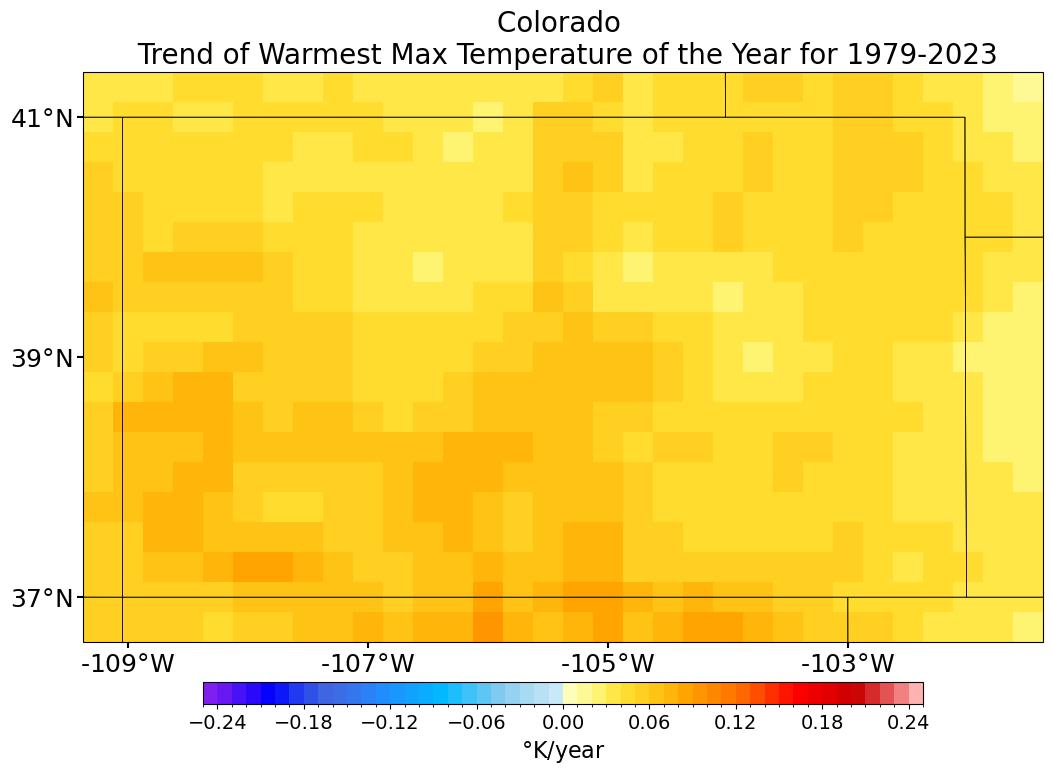

In [58]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,11),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15,left=0.1, right=0.9)
cc=trend_tmax['polyfit_coefficients'].sel(degree=1).plot.pcolormesh(ax=ax,cmap=cmap,levels=np.arange(-0.25,0.26,0.01),add_colorbar=False)
####
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'{units}/year',fontsize=16)

ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()
ax.set_title(f'Colorado \n Trend of Warmest Max Temperature of the Year for {yearb}-{yeare}',fontsize=20)  
plt.suptitle('')    
outfile=f'PLOTS/Trend_Warmest_Tmax_{yearb}_{yeare}_COLORADO.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Timeseries

Location |                    GHCND Code |	      Lat |	        Lon |	Elev (m)|
|----------|:--------:|---------|---------|---------|
Durango Airport				 |   USW00093005	|    37.1431	|	-107.76023	|2020.6  |
Hayden						 |   USC00053867    |    40.4926	|	-107.2548	|1971.1  |
Fraser						 |   USC00053113	|    39.95		|   -105.83333	|2609.1  |
Fruita (near Grand Junction) |	 UC00053146		|    39.14449	|   -108.728	|1371    |
Grand Junction Airport		 |	 USW00023066 	|    39.13437	|   -108.54081	|1470.4  |
Colorado Springs Airport	 |	 USW00093037	|    38.80949	|   -104.68873	|1884.2  |
Denver (downtown)			 |   USW00093002	|    39.75		|   -104.98333	|1623.1  |
Pueblo WFO (Airport)		 |	 USC00058992	|    38.2798	|	-104.5215	|1418.2  |
Springfield					 |   USC00057862	|    37.4		|   -102.61667	|1344.5  |
Sterling					 |	 USC00057950	|    40.6279	|	-103.2084	|1211.3  |

In [59]:
ptlon = [-107.76023, -107.2548, -105.83333,  -108.728, -108.54081,-104.68873, -104.98333, -104.5215, -102.61667, -103.2084]
ptlat = [ 37.1431, 40.4926, 39.95, 39.14449, 39.13437, 38.80949,39.75, 38.2798, 37.4, 40.6279 ]
ptlabel=['Durango', 'Hayden', 'Fraser', 'Fruita', 'Grand Junction', 'Colorado Springs', 'Denver', 'Pueblo', 'Springfield', 'Sterling']

<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_594182/861068195.py:24: SyntaxWarning: invalid escape sequence '\d'
  ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
/tmp/ipykernel_594182/861068195.py:26: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)


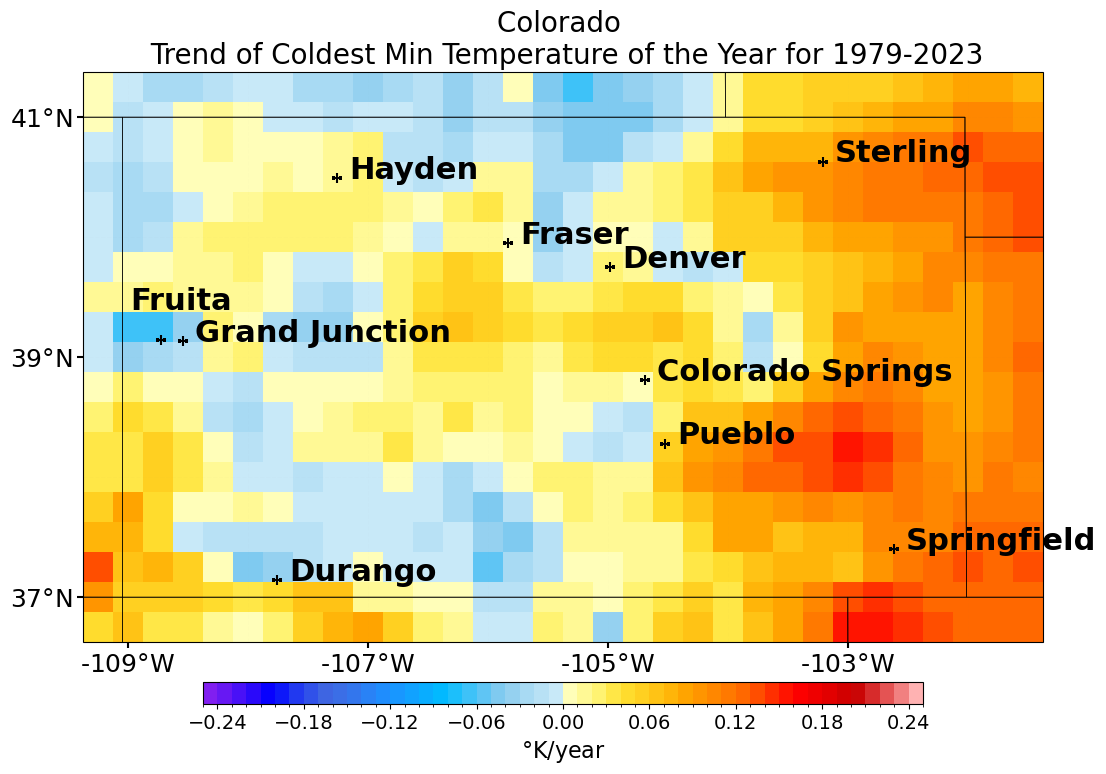

In [60]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,11),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15,left=0.1, right=0.9)
cc=trend_tmin['polyfit_coefficients'].sel(degree=1).plot.pcolormesh(ax=ax,cmap=cmap,levels=np.arange(-0.25,0.26,0.01),add_colorbar=False)
for ip in range(0,len(ptlon)):
  if ptlabel[ip] == 'Fruita': 
    ax.scatter(ptlon[ip]+360,ptlat[ip],marker='+',color='k',s=50)
    ax.text(ptlon[ip]-0.25,ptlat[ip]+0.25,f'{ptlabel[ip]}',color='k',size=22,weight='bold')
  else:
    ax.scatter(ptlon[ip]+360,ptlat[ip],marker='+',color='k',s=50)
    ax.text(ptlon[ip]+0.1,ptlat[ip],f'{ptlabel[ip]}',color='k',size=22,weight='bold')
####
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'{units}/year',fontsize=16)

ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()
ax.set_title(f'Colorado \n Trend of Coldest Min Temperature of the Year for {yearb}-{yeare}',fontsize=20)  
plt.suptitle('')  
outfile=f'PLOTS/Trend_Coldest_Tmin_{yearb}_{yeare}_COLORADO_wStations.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

Nearest Neighbor Interpolation

<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:27: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_594182/3113450880.py:25: SyntaxWarning: invalid escape sequence '\d'
  ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
/tmp/ipykernel_594182/3113450880.py:27: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)


Text(0.5, 0.98, '')

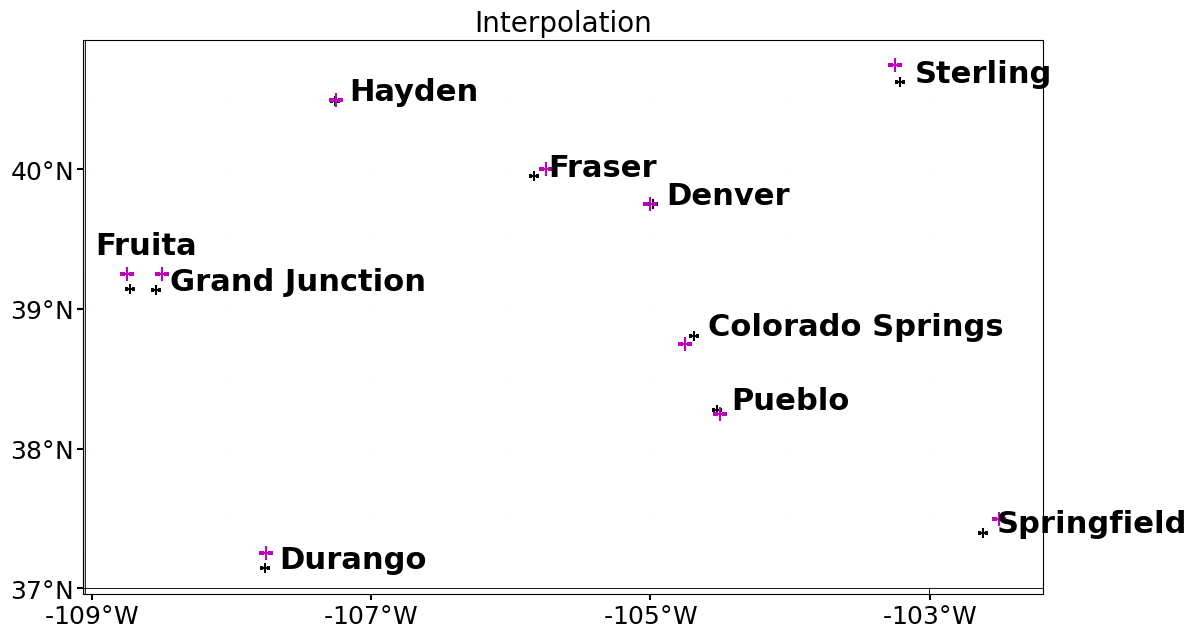

In [61]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,11),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15,left=0.1, right=0.9)
for ip in range(0,len(ptlon)):
  if ptlabel[ip] == 'Fruita': 
    ax.scatter(ptlon[ip]+360,ptlat[ip],marker='+',color='k',s=50)
    ax.text(ptlon[ip]-0.25,ptlat[ip]+0.25,f'{ptlabel[ip]}',color='k',size=22,weight='bold')
  else:
    ax.scatter(ptlon[ip]+360,ptlat[ip],marker='+',color='k',s=50)
    ax.text(ptlon[ip]+0.1,ptlat[ip],f'{ptlabel[ip]}',color='k',size=22,weight='bold')
  ax.scatter(dstmax['lon'].sel(lon=ptlon[ip]+360,method='nearest'),dstmax['lat'].sel(lat=ptlat[ip],method='nearest'),\
             marker='+',color='m',s=100)  
####
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)

ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()
ax.set_title(f'Interpolation',fontsize=20)  
plt.suptitle('')  

In Black, location of the GHCND stations. In Magenta, nearest ERA5 grid points.

<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_594182/2498652596.py:23: SyntaxWarning: invalid escape sequence '\d'
  ax1.set_ylabel(f'Tmin ($\degree$K)', color='k',fontsize=16)


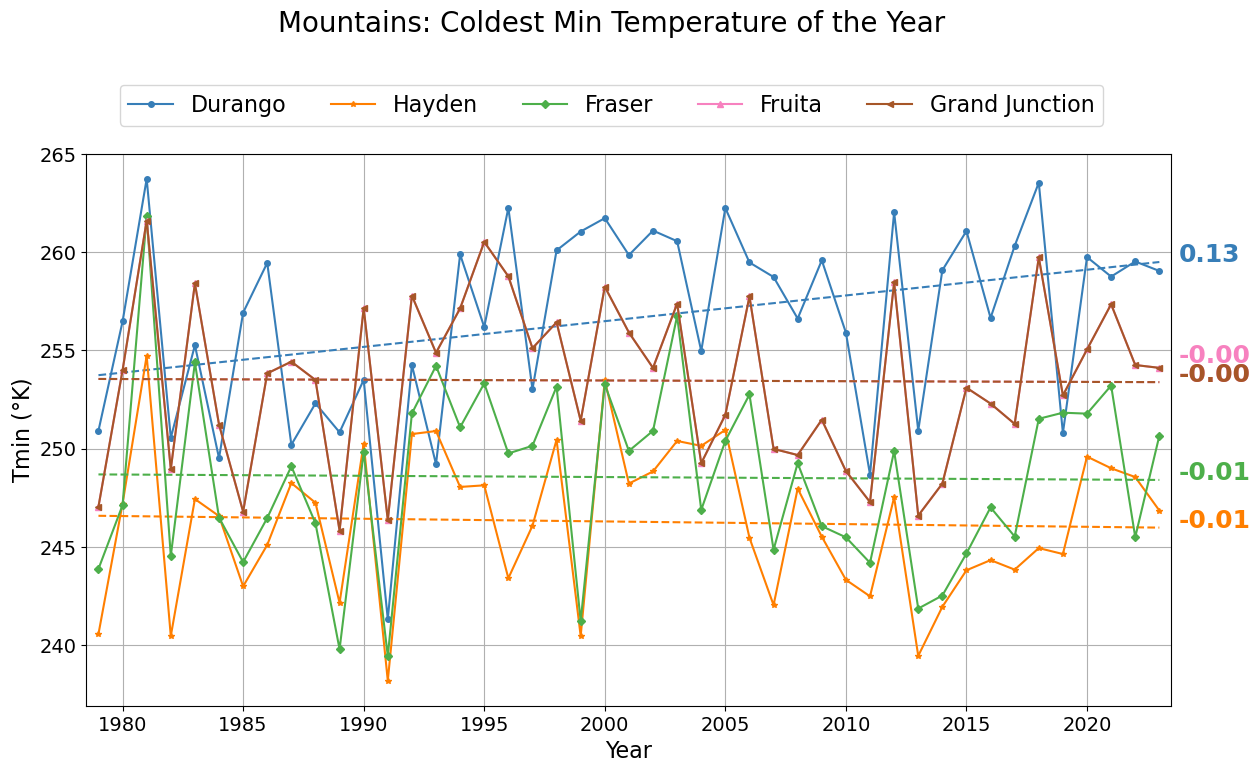

In [62]:
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00','#000000']
markers = ['o','*','D','^','<','>','v','P','X','s']

#####
fig, ax1 = plt.subplots(figsize=(14,8))
plt.subplots_adjust(top=0.8)
#ax2 = ax1.twinx()
for ij in range(0,5): 
  aij = trend_tmin['polyfit_coefficients'].sel(degree=1).sel(lon=ptlon[ij],lat=ptlat[ij],method='nearest')
  bij = trend_tmin['polyfit_coefficients'].sel(degree=0).sel(lon=ptlon[ij],lat=ptlat[ij],method='nearest')
  ax1.plot(np.arange(yearb,yeare+1,1),dstmin['coldest_tmin'].sel(lon=ptlon[ij],lat=ptlat[ij],method='nearest'),\
           color=colors[ij],marker=markers[ij],markersize=4,label=f'{ptlabel[ij]}')
  lines=np.arange(yearb,yeare+1,1)*aij.values + bij.values
  ax1.plot(np.arange(yearb,yeare+1,1),lines,
           color=colors[ij],linestyle='--')
  ax1.text(yeare+0.8,lines[-1],f'{aij.values:0.2f}',color=colors[ij],size=18,weight='bold')
  if ptlabel[ij]=='Fruita':
    ax1.text(yeare+0.8,lines[-1]+1,f'{aij.values:0.2f}',color=colors[ij],size=18,weight='bold')
ax1.set_xlim(1978.5,2023.5)

ax1.set_ylabel(f'Tmin ($\degree$K)', color='k',fontsize=16)
ax1.tick_params(axis='x', labelcolor='k',labelsize=14)
ax1.tick_params(axis='y', labelcolor='k',labelsize=14)
ax1.set_xlabel('Year',fontsize=16)
ax1.grid()
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=5,bbox_to_anchor=(0.5,0.9),prop={'size': 16})
plt.suptitle('Mountains: Coldest Min Temperature of the Year',fontsize=20)
outfile=f'PLOTS/Coldest_Tmin_timeseries_COLORADO_mountains.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

Fruita and Grand Junction timeseries are superposed.

<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_594182/80441823.py:21: SyntaxWarning: invalid escape sequence '\d'
  ax1.set_ylabel(f'Tmin ($\degree$K)', color='k',fontsize=16)


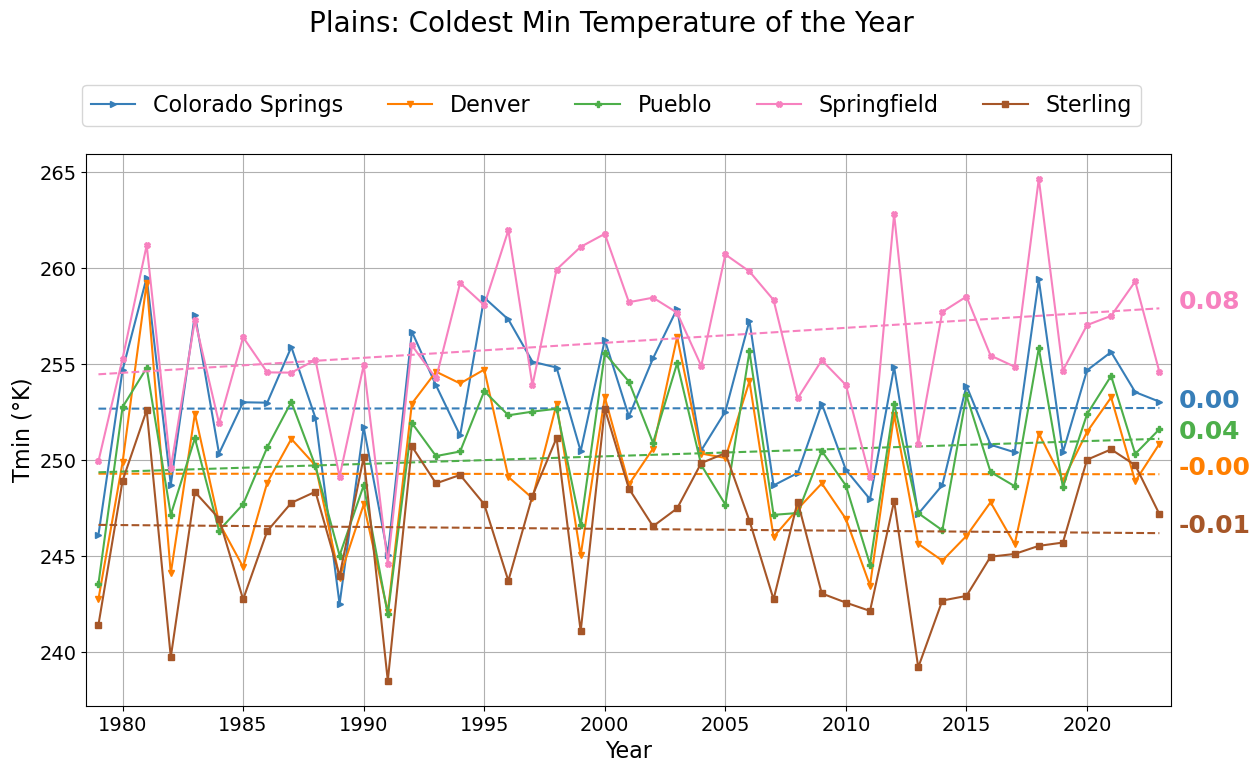

In [63]:
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00','#000000']
markers = ['o','*','D','^','<','>','v','P','X','s']

#####
fig, ax1 = plt.subplots(figsize=(14,8))
plt.subplots_adjust(top=0.8)
#ax2 = ax1.twinx()
for ij in range(5,len(ptlon)): 
  aij = trend_tmin['polyfit_coefficients'].sel(degree=1).sel(lon=ptlon[ij],lat=ptlat[ij],method='nearest')
  bij = trend_tmin['polyfit_coefficients'].sel(degree=0).sel(lon=ptlon[ij],lat=ptlat[ij],method='nearest')
  ax1.plot(np.arange(yearb,yeare+1,1),dstmin['coldest_tmin'].sel(lon=ptlon[ij],lat=ptlat[ij],method='nearest'),\
           color=colors[ij-5],marker=markers[ij],markersize=4,label=f'{ptlabel[ij]}')
  lines=np.arange(yearb,yeare+1,1)*aij.values + bij.values
  ax1.plot(np.arange(yearb,yeare+1,1),lines,
           color=colors[ij-5],linestyle='--')
  ax1.text(yeare+0.8,lines[-1],f'{aij.values:0.2f}',color=colors[ij-5],size=18,weight='bold')
ax1.set_xlim(1978.5,2023.5)

ax1.set_ylabel(f'Tmin ($\degree$K)', color='k',fontsize=16)
ax1.tick_params(axis='x', labelcolor='k',labelsize=14)
ax1.tick_params(axis='y', labelcolor='k',labelsize=14)
ax1.set_xlabel('Year',fontsize=16)
ax1.grid()
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=5,bbox_to_anchor=(0.5,0.9),prop={'size': 16})
plt.suptitle('Plains: Coldest Min Temperature of the Year',fontsize=20)
outfile=f'PLOTS/Coldest_Tmin_timeseries_COLORADO_plains.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_594182/4118239109.py:24: SyntaxWarning: invalid escape sequence '\d'
  ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
/tmp/ipykernel_594182/4118239109.py:26: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)


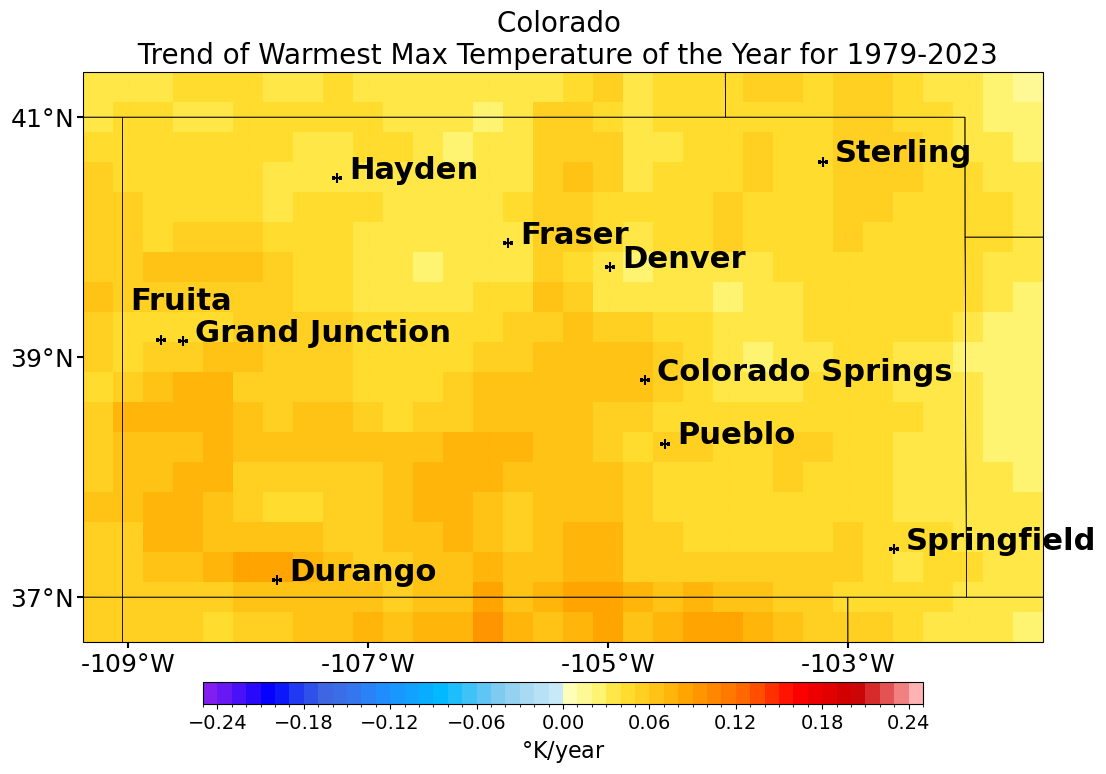

In [64]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,11),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15,left=0.1, right=0.9)
cc=trend_tmax['polyfit_coefficients'].sel(degree=1).plot.pcolormesh(ax=ax,cmap=cmap,levels=np.arange(-0.25,0.26,0.01),add_colorbar=False)
for ip in range(0,len(ptlon)):
  if ptlabel[ip] == 'Fruita': 
    ax.scatter(ptlon[ip]+360,ptlat[ip],marker='+',color='k',s=50)
    ax.text(ptlon[ip]-0.25,ptlat[ip]+0.25,f'{ptlabel[ip]}',color='k',size=22,weight='bold')
  else:
    ax.scatter(ptlon[ip]+360,ptlat[ip],marker='+',color='k',s=50)
    ax.text(ptlon[ip]+0.1,ptlat[ip],f'{ptlabel[ip]}',color='k',size=22,weight='bold')
####
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'{units}/year',fontsize=16)

ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()
ax.set_title(f'Colorado \n Trend of Warmest Max Temperature of the Year for {yearb}-{yeare}',fontsize=20)  
plt.suptitle('')   
outfile=f'PLOTS/Trend_Warmest_Tmax_{yearb}_{yeare}_COLORADO_wStations.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_594182/2608642326.py:23: SyntaxWarning: invalid escape sequence '\d'
  ax1.set_ylabel(f'Tmin ($\degree$K)', color='k',fontsize=16)


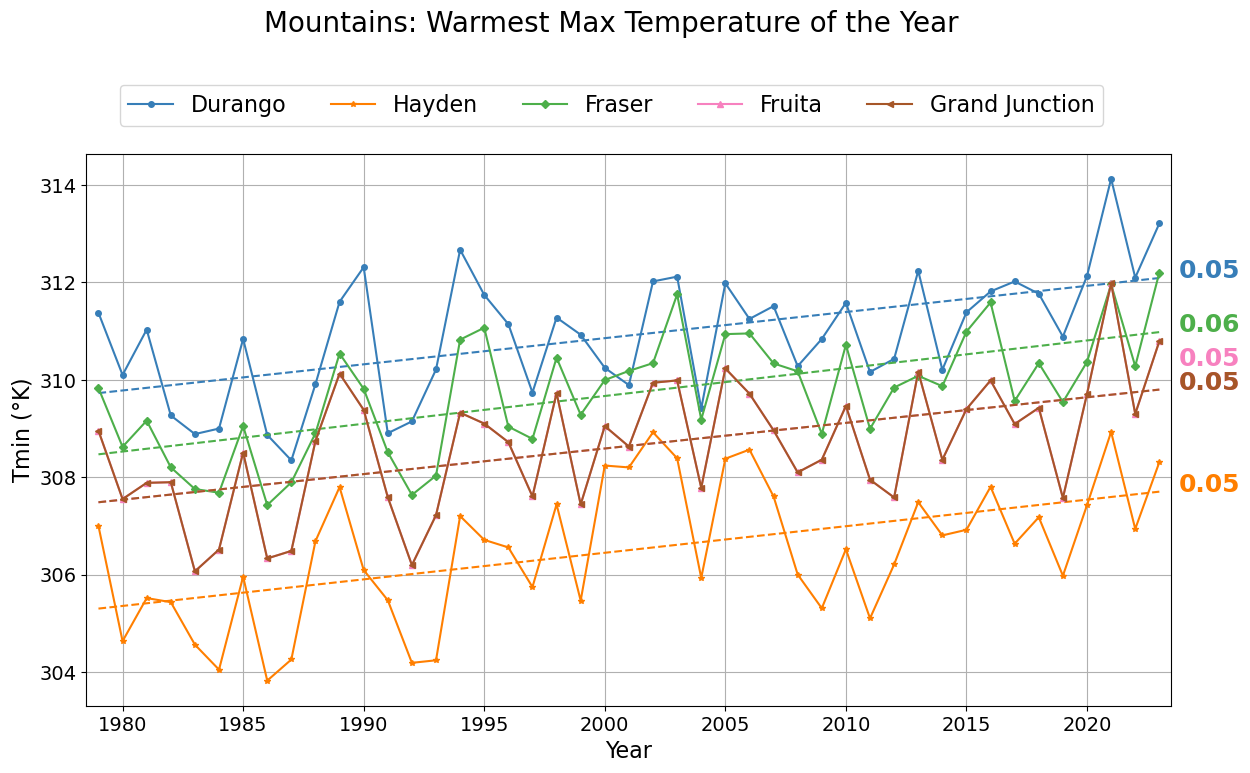

In [75]:

colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00','#000000']
markers = ['o','*','D','^','<','>','v','P','X','s']

#####
fig, ax1 = plt.subplots(figsize=(14,8))
plt.subplots_adjust(top=0.8)
#ax2 = ax1.twinx()
for ij in range(0,5): 
  aij = trend_tmax['polyfit_coefficients'].sel(degree=1).sel(lon=ptlon[ij],lat=ptlat[ij],method='nearest')
  bij = trend_tmax['polyfit_coefficients'].sel(degree=0).sel(lon=ptlon[ij],lat=ptlat[ij],method='nearest')
  ax1.plot(np.arange(yearb,yeare+1,1),dstmax['hottest_tmax'].sel(lon=ptlon[ij],lat=ptlat[ij],method='nearest'),\
           color=colors[ij],marker=markers[ij],markersize=4,label=f'{ptlabel[ij]}')
  lines=np.arange(yearb,yeare+1,1)*aij.values + bij.values
  ax1.plot(np.arange(yearb,yeare+1,1),lines,
           color=colors[ij],linestyle='--')
  ax1.text(yeare+0.8,lines[-1],f'{aij.values:0.2f}',color=colors[ij],size=18,weight='bold')
  if ptlabel[ij]=='Fruita':
    ax1.text(yeare+0.8,lines[-1]+0.5,f'{aij.values:0.2f}',color=colors[ij],size=18,weight='bold')
ax1.set_xlim(1978.5,2023.5)

ax1.set_ylabel(f'Tmin ($\degree$K)', color='k',fontsize=16)
ax1.tick_params(axis='x', labelcolor='k',labelsize=14)
ax1.tick_params(axis='y', labelcolor='k',labelsize=14)
ax1.set_xlabel('Year',fontsize=16)
ax1.grid()
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=5,bbox_to_anchor=(0.5,0.9),prop={'size': 16})

plt.suptitle('Mountains: Warmest Max Temperature of the Year',fontsize=20)
outfile=f'PLOTS/Warmest_Tmax_timeseries_COLORADO_mountains.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

Fruita and Grand Junction timeseries are superposed.

<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_594182/1624061970.py:20: SyntaxWarning: invalid escape sequence '\d'
  ax1.set_ylabel(f'$\degree$K', color='k',fontsize=16)


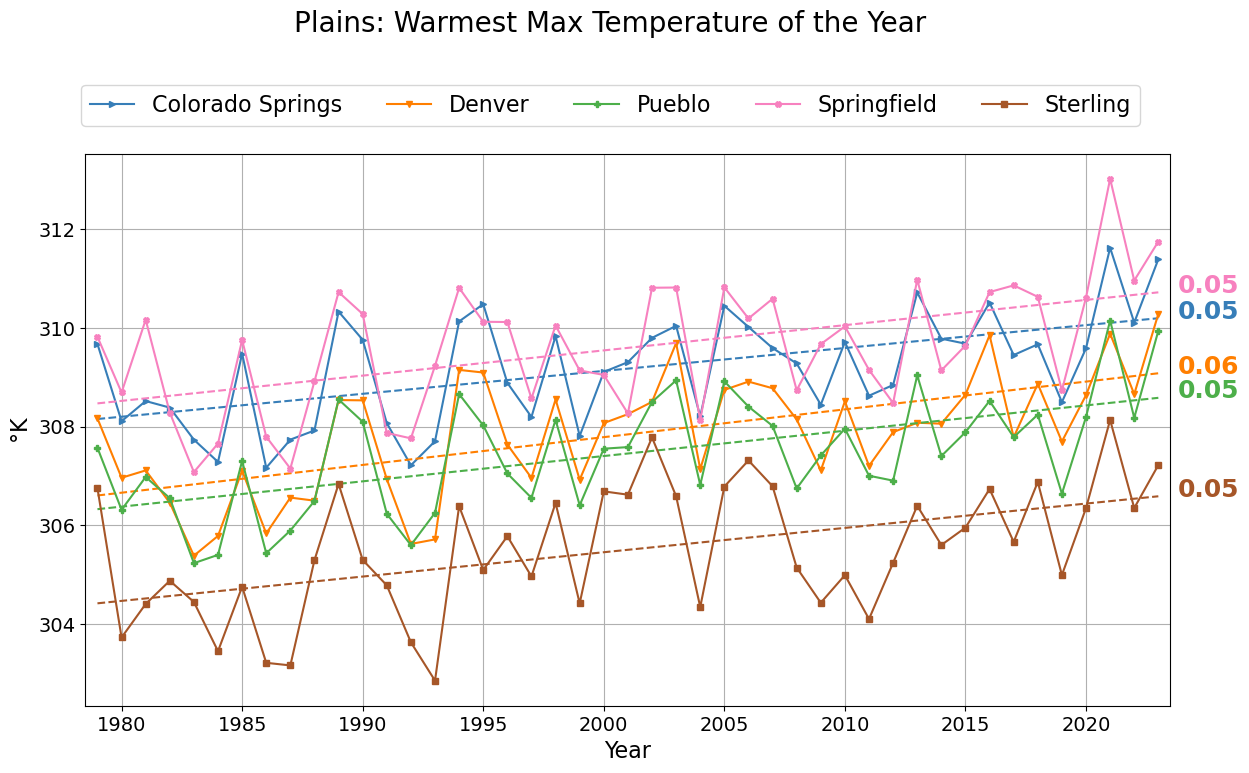

In [66]:

colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00','#000000']
markers = ['o','*','D','^','<','>','v','P','X','s']

#####
fig, ax1 = plt.subplots(figsize=(14,8))
plt.subplots_adjust(top=0.8)
#ax2 = ax1.twinx()
for ij in range(5,len(ptlon)): 
  aij = trend_tmax['polyfit_coefficients'].sel(degree=1).sel(lon=ptlon[ij],lat=ptlat[ij],method='nearest')
  bij = trend_tmax['polyfit_coefficients'].sel(degree=0).sel(lon=ptlon[ij],lat=ptlat[ij],method='nearest')
  ax1.plot(np.arange(yearb,yeare+1,1),dstmax['hottest_tmax'].sel(lon=ptlon[ij],lat=ptlat[ij],method='nearest'),\
           color=colors[ij-5],marker=markers[ij],markersize=4,label=f'{ptlabel[ij]}')
  lines=np.arange(yearb,yeare+1,1)*aij.values + bij.values
  ax1.plot(np.arange(yearb,yeare+1,1),lines,
           color=colors[ij-5],linestyle='--')
  ax1.text(yeare+0.8,lines[-1],f'{aij.values:0.2f}',color=colors[ij-5],size=18,weight='bold')
ax1.set_xlim(1978.5,2023.5)
ax1.set_ylabel(f'$\degree$K', color='k',fontsize=16)
ax1.tick_params(axis='x', labelcolor='k',labelsize=14)
ax1.tick_params(axis='y', labelcolor='k',labelsize=14)
ax1.set_xlabel('Year',fontsize=16)
ax1.grid()
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=5,bbox_to_anchor=(0.5,0.9),prop={'size': 16})

plt.suptitle('Plains: Warmest Max Temperature of the Year',fontsize=20)
outfile=f'PLOTS/Warmest_Tmax_timeseries_COLORADO_plains.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Regression onto GLOST

In [83]:
reg_tmin = regcoeff_array(dstmin['coldest_tmin'],ann_glost,'year')
reg_tmax = regcoeff_array(dstmax['hottest_tmax'],ann_glost,'year')

In [84]:
print(reg_tmin.min().values,reg_tmin.max().values)
print(reg_tmax.min().values,reg_tmax.max().values)

-0.018033666880509773 0.03658799479685631
0.017522940319234508 0.14968480717278504


<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_594182/1192291178.py:18: SyntaxWarning: invalid escape sequence '\d'
  ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
/tmp/ipykernel_594182/1192291178.py:20: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)


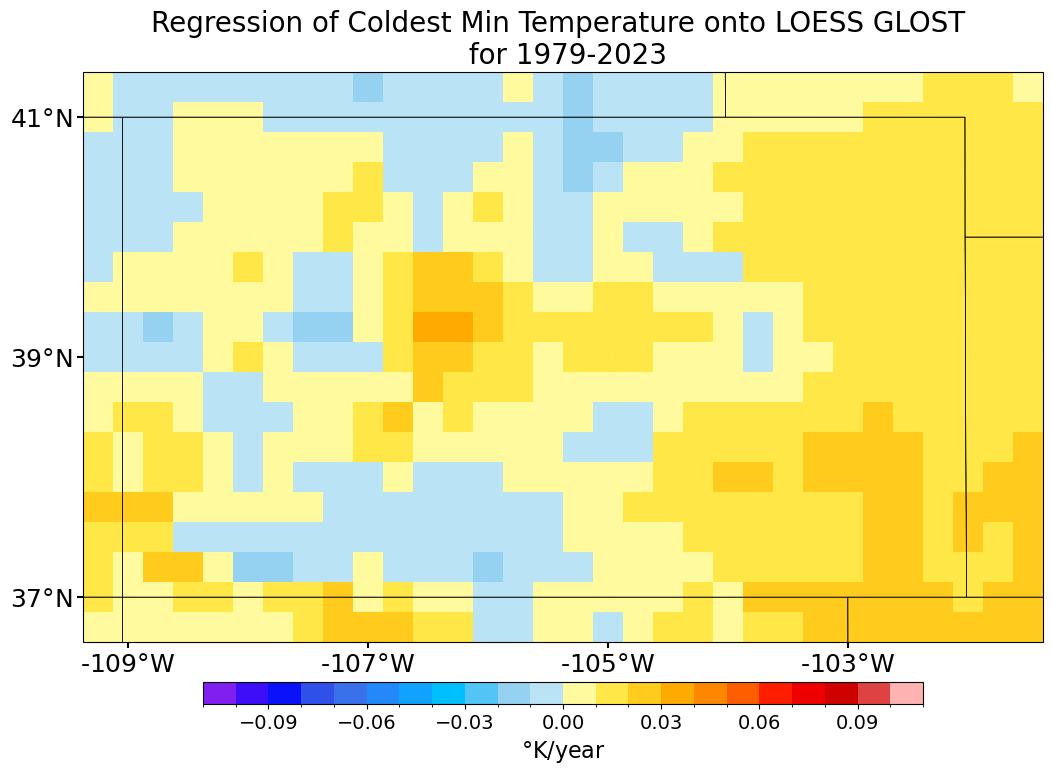

In [85]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,11),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15,left=0.1, right=0.9)

cc=reg_tmin.plot.pcolormesh(ax=ax,cmap=cmap,levels=np.arange(-0.11,0.12,0.01),add_colorbar=False)
####
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'{units}/year',fontsize=16)

ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()
ax.set_title(f'Regression of Coldest Min Temperature onto LOESS GLOST \n for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Regression_Coldest_Tmin_GLOST_{yearb}_{yeare}_COLORADO.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_594182/3369174994.py:18: SyntaxWarning: invalid escape sequence '\d'
  ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
/tmp/ipykernel_594182/3369174994.py:20: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)


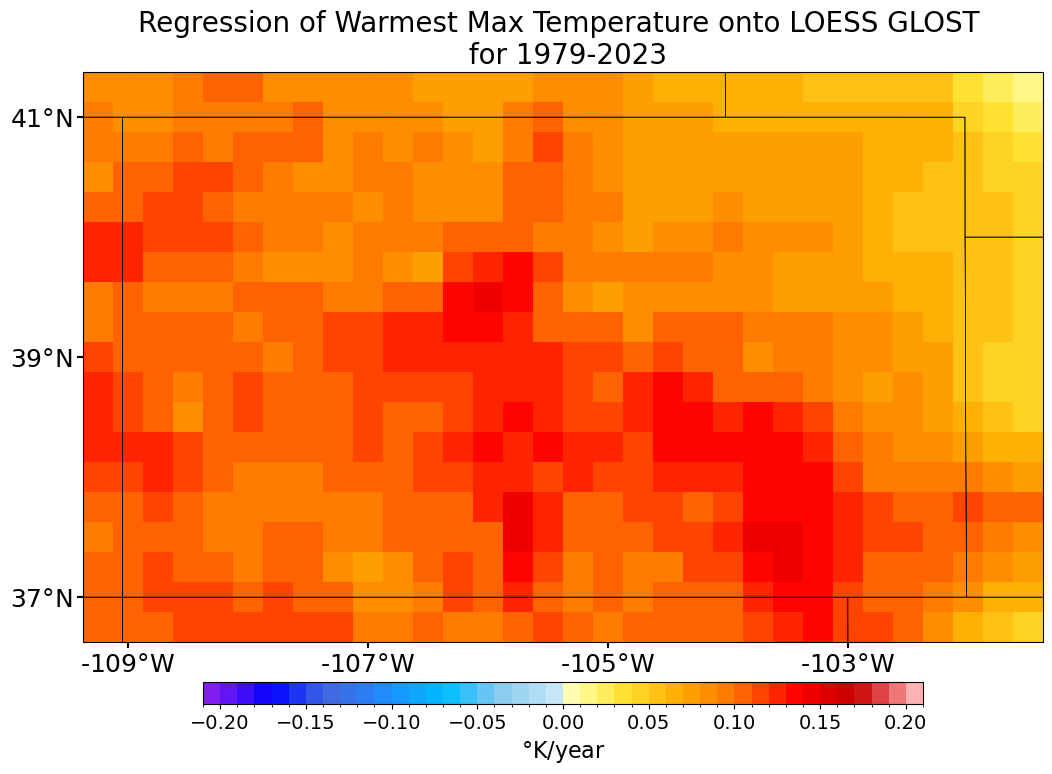

In [86]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,11),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15,left=0.1, right=0.9)

cc=reg_tmax.plot.pcolormesh(ax=ax,cmap=cmap,levels=np.arange(-0.21,0.22,0.01),add_colorbar=False)
####
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'{units}/year',fontsize=16)

ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()
ax.set_title(f'Regression of Warmest Max Temperature onto LOESS GLOST \n for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Regression_Warmest_Tmax_GLOST_{yearb}_{yeare}_COLORADO.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Correlation onto GLOST

In [87]:
cor_tmin = rvalue_array(dstmin['coldest_tmin'],ann_glost,'year')
cor_tmax = rvalue_array(dstmax['hottest_tmax'],ann_glost,'year')

pvalue_tmin = pvalue_array(dstmin['coldest_tmin'],ann_glost,'year')
pvalue_tmax = pvalue_array(dstmax['hottest_tmax'],ann_glost,'year')

In [88]:
print(cor_tmin.min().values,cor_tmin.max().values)
print(cor_tmax.min().values,cor_tmax.max().values)

-0.216469275868288 0.44410658726235996
0.12229004834085225 0.7178362687355131


<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_594182/3618855183.py:21: SyntaxWarning: invalid escape sequence '\d'
  ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
/tmp/ipykernel_594182/3618855183.py:23: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)


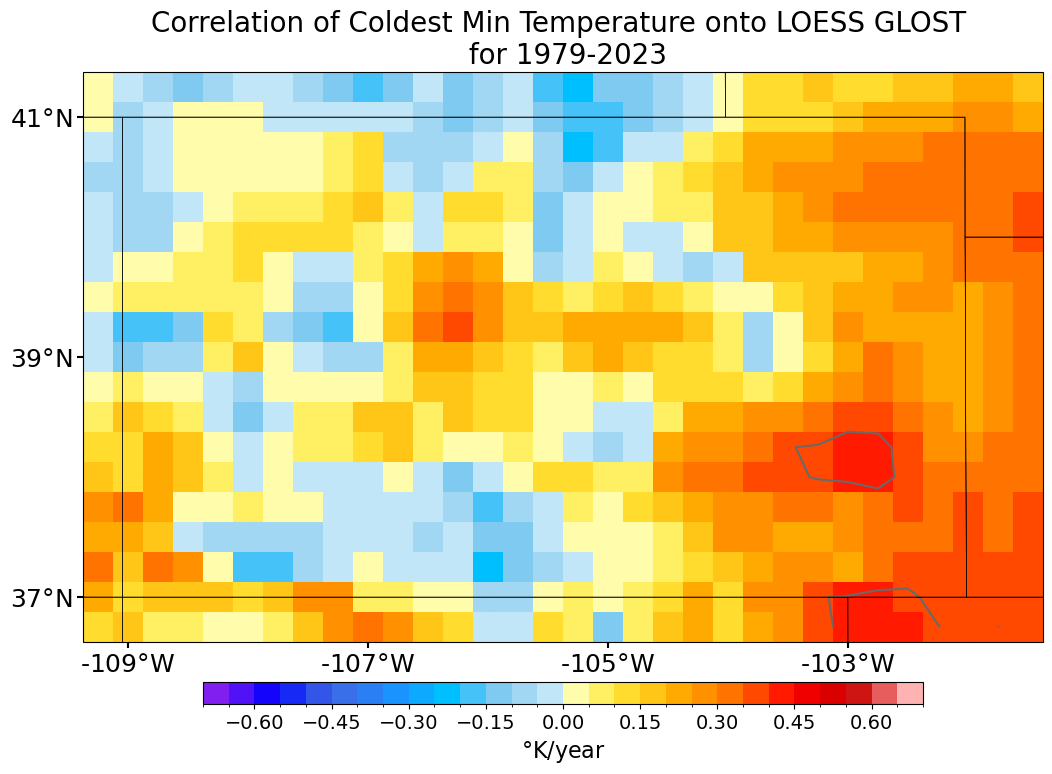

In [89]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

clevs = np.arange(-0.7,.75,0.05)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,11),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15,left=0.1, right=0.9)

cc=cor_tmin.plot.pcolormesh(ax=ax,cmap=cmap,levels=clevs,add_colorbar=False)
ax.contour(pvalue_tmin['lon'],pvalue_tmin['lat'],pvalue_tmin,levels=[0.01],colors='dimgrey')
####
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'{units}/year',fontsize=16)

ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()

ax.set_title(f'Correlation of Coldest Min Temperature onto LOESS GLOST \n for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Correlation_Coldest_tmin_GLOST_{yearb}_{yeare}_COLORADO.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

Grey contour marks significance at 90%.

<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_594182/105887887.py:21: SyntaxWarning: invalid escape sequence '\d'
  ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
/tmp/ipykernel_594182/105887887.py:23: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)


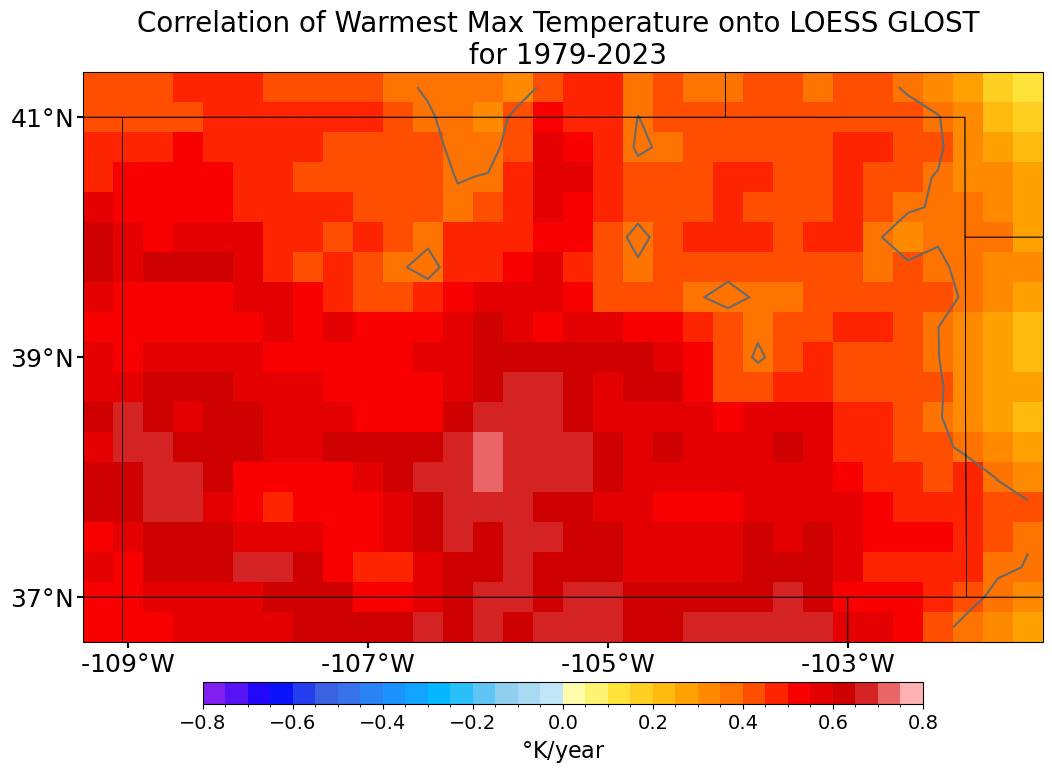

In [90]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

clevs = np.arange(-0.8,.85,0.05)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,11),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15,left=0.1, right=0.9)

cc=cor_tmax.plot.pcolormesh(ax=ax,cmap=cmap,levels=clevs,add_colorbar=False)
ax.contour(pvalue_tmax['lon'],pvalue_tmax['lat'],pvalue_tmax,levels=[0.01],colors='dimgrey')
####
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'{units}/year',fontsize=16)

ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()
ax.set_title(f'Correlation of Warmest Max Temperature onto LOESS GLOST \n for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Correlation_Warmest_tmax_GLOST_{yearb}_{yeare}_COLORADO.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

Grey contour marks significance at 90%.